# Space Object (SO) Propagation Using Estimated Thermospheric Density

1. Load TLE data. 
2. Load ballistic coefficient data. 
3. Generate observations from TLE data. 
4. Generate reduced-order density model.
5. Initialize reduced-order density state. 
6. Set initial orbital state guesses.
7. Propagate space object using estimated thermospheric density.
8. Data visualization

In [1]:
## Import packages
import numpy as np
import datetime 
import spiceypy as spice
import scipy.io as sio
from python_utils.astro_function_jit import loc_gravLegendre_scaleFactor, inputEOP_Celestrak, loadSGP4, get_julian_datetime, inputSWnrlmsise, inputSWtiegcm, inputEOP_Celestrak_Full, readSOLFSMY
from python_utils.astro_function_jit import generateObservationsMEE, generateROMdensityModel, getDensityJB2008llajd, ep2pv_jit, UKF, readDTCFILE, from_jd, getTLEsForEstimation, propagateState_MeeBcRom

import os 
import matplotlib.pyplot as plt
%matplotlib inline 

os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'

### SETTINGS
Specify the date, reduced-order model, reduction order and objects to be
used to estimation here.

In [2]:
# Estimation window
yr      = 2020; # Year
mth     = 1;    # Month
dy      = 3;    # Day
nofDays = 0;   # Number of days
nofHours = 6;  # Number of hours

# Use high fidelity dynamical model
highFidelity = True;

# Reduced-order model
ROMmodel = 'JB2008_1999_2010';  # Name of reduced-order density model: JB2008_1999_2010
r  = 10;                        # Reduced order

# NORAD catalog IDs of objects used for estimation
# 20 objects : Jan 3-28, 2020
selectedObjects = (22,614,932,1807,2153,2389,4221,4382,7337,8744,12138,12388,14483,20774,23278,41771,41772,41773,42989,43797);

### LOAD KERNELS, GRAVITY MODEL, EARTH ORIENTATION PARAMETERS AND SGP4

In [3]:
# Load SPICE kernels and ephemerides
spice.furnsh("Data/kernel.txt")

# Load gravity model
if highFidelity:
    gravmodeldegree  = 48;  # Use degree and order 48 for the spherical harmonics
else:
    gravmodeldegree  = 20;  # Use degree and order 20 for the spherical harmonics

# loads gravity model.
EGM2008 = sio.loadmat('Data/EGM2008.mat')
#,'GM', 'Re', 'degree', 'C', 'S'); # [GM, Re, degree, C, S]

GM = EGM2008['GM']
Re = EGM2008['Re']
degree = EGM2008['degree']
C = EGM2008['C']
S = EGM2008['S']

if gravmodeldegree > degree:
    print('Degree must be less than or equal to maximum degree of EGM2008 model. ',
        'Setting maximum degree to the maximum degree of the EGM2008 model.');
    gravmodeldegree = degree;
    
gravdegree = gravmodeldegree;
C_gravmodel = C[0:gravmodeldegree+2,0:gravmodeldegree+2];
S_gravmodel = S[0:gravmodeldegree+2,0:gravmodeldegree+2];

sF_gravmod = loc_gravLegendre_scaleFactor(gravmodeldegree);

# Set Earth constants
gravconst    = 6.67259e-20; # [km^3/kg/s^2]
Earth_radius = Re/1e3; # [km]
Earth_mass   = GM*1e-9/gravconst; # [kg]

# Load Earth orientation parameters (needed for TEME to ECI transformation)
EOPMat = inputEOP_Celestrak( "Data/EOP-All.txt" );

[tumin, mu, radiusearthkm, xke, j2, j3, j4, j3oj2, opsmode, whichconst] = loadSGP4()

In [4]:
GM_kms = GM*1e-9; # Earth gravitational parameter according to accurate gravity model [km^3 s^-2]

## Datetime
# Always start at midnight
hr=0; mn=0; sc=0; 

# julian datatime
jd0 = get_julian_datetime(datetime.datetime(yr,mth,dy,0,0,0));
jdf = get_julian_datetime(datetime.datetime(yr,mth,dy+nofDays,nofHours,0,0));

# Time Interval for measurements
dt = 3600;
tf = (jdf-jd0)*24*60*60;
time = np.arange(0,tf+dt,dt); 
m=len(time);

## Load space weather data
SWpath = 'Data/SW-All.txt';
[ SWmatDaily, SWmatMonthlyPred ] = inputSWnrlmsise( SWpath );
[ SWmatDailyTIEGCM, SWmatMonthlyPredTIEGCM ] = inputSWtiegcm( SWpath );

## Load space weather data and Earth orientation parameters needed for JB2008 density model from file
# Read Earth orientation parameters
eopdata = inputEOP_Celestrak_Full('Data/EOP-All.txt');

# Read space weather data: solar activity indices
SOLdata = readSOLFSMY('Data/SOLFSMY.txt');

# Read geomagnetic storm DTC values
DTCdata = readDTCFILE('Data/DTCFILE.txt');

## Load TLE data

In [5]:
# Load a bit more TLEs than needed to plot the TLE data 
maxAlt = 10000; # Maximum altitude of apogee [km], TLEs for objects with higher apogee will not be downloaded
jdate0TLEs = get_julian_datetime(datetime.datetime(yr,mth,1,0,0,0)); # Start date of TLE collection window 
dt_jdf = from_jd(jdf+30);  # End date of TLE collection window 
yrf = dt_jdf.year
mthf = dt_jdf.month
dyf = dt_jdf.day

# Read downloaded TLE data
objects, TLE_jdsatepoch = getTLEsForEstimation(yr, mth, 1, yrf, mthf, dyf, selectedObjects);

## Load Ballistic Coefficient data

In [6]:
# Ballistic coefficient data: NORAD ID and BC
filename = 'Data/BCdata.txt'
BCdata = np.loadtxt(filename, delimiter="\t",skiprows=2)

BCestimates = np.zeros((len(selectedObjects),1))
for ik in range(0,len(selectedObjects)):
    # Ballistic coefficient
    BCestimates[ik] = BCdata[BCdata[:,0]==selectedObjects[ik],1]
    
# Number of objects
nop = len(objects);

# Cell with object ID text strings
objectIDlabels = list(objects.keys())

## Generate observations from TLE data

In [7]:
obsEpochs = np.arange(jd0,jdf+dt/86400,dt/86400);
meeMeas = generateObservationsMEE(objects,TLE_jdsatepoch,obsEpochs,GM_kms,EOPMat);

## Generate reduced-order density model

In [8]:
## Load reduced-order density models
AC,BC,Uh,F_U,Dens_Mean,M_U,SLTm,LATm,ALTm,maxAtmAlt,SWinputs,Qrom = generateROMdensityModel(ROMmodel,r,jd0,jdf,spice)

## Initialize reduced order density state

In [9]:
# Use orbital state from TLE as initial orbital state guess
x0orbits = meeMeas[:,0];

# Size of state vector for each object [3xpos,3xvel,1xBC]
svs = 7;

# Initial state guess: Orbits, BCs and reduced order density
x0g = np.zeros((svs*nop+r,1));
for i in range (0,nop):
    # Orbital state guesses
    x0g[svs*(i):svs*(i)+6,0] = x0orbits[6*(i):6*(i)+6];
    # Ballistic coefficient guesses
    x0g[svs*(i+1)-1] = BCestimates[i] * 1000;
    
# Compute the initial atmosphere state from JB2008 density model
# Seconds of day in UTC
UT = hr*3600+mn*60+sc;

# Grid points of ROM model
sltx = np.reshape(np.swapaxes(SLTm,0,1),(SLTm.shape[0]*SLTm.shape[1]*SLTm.shape[2],1), order='F');
latx = np.reshape(np.swapaxes(LATm,0,1),(SLTm.shape[0]*SLTm.shape[1]*SLTm.shape[2],1), order='F');
altx = np.reshape(ALTm,(SLTm.shape[0]*SLTm.shape[1]*SLTm.shape[2],1), order='F');

# Density at grid points according to JB2008 density model
Dens_JB2008 = np.zeros((len(sltx),1));
for i in range(0,len(sltx)):
    # Geographical longitude
    lon = 15*(sltx[i]-UT/3600);
    # Density from JB2008 density model
    Dens_JB2008[i,0] = getDensityJB2008llajd(lon,latx[i],altx[i],jd0,eopdata,SOLdata,DTCdata,spice) * 1e-9;

# Initialize state for ROM using JB2008
z0_M = Uh.T@(np.log10(Dens_JB2008)-Dens_Mean); # JB2008 initialization

# Add initial ROM state to initial state guess
x0g[-r:,0] = z0_M.flatten();

## Set initial orbital state guesses

In [10]:
## Density estimation
# State estimate
X_est = x0g; # Initial state guess

# Initial Ephemeris Time (ET): ET is the number of seconds past the 
# epoch of the J2000 reference frame in the time system known as 
# Barycentric Dynamical Time (TDB).
et0  = spice.spiceypy.str2et(from_jd(jd0).strftime("%Y %m %d %H %M %S"))

## Propagate SO using estimated thermospheric density

In [11]:
X_est_temp = np.zeros((X_est.shape[0],len(time)))
X_est_temp[:,0] = X_est.flatten()

for ik in range(0,len(time)-1):
    print(ik,len(time)-1)
    X_est_temp[:,ik+1] = (propagateState_MeeBcRom(X_est_temp[:,ik],time[ik],time[ik+1],AC,BC,SWinputs,r,nop,svs,F_U,M_U,maxAtmAlt,et0,jd0,highFidelity,GM, Re, C_gravmodel, S_gravmodel, gravdegree, sF_gravmod)).flatten()
    
X_est = X_est_temp

0 6
1 6
2 6
3 6
4 6
5 6


## Data visualization

Text(0.5, 0.98, 'Equinoctial orbital elements and 3$\\sigma$ bounds')

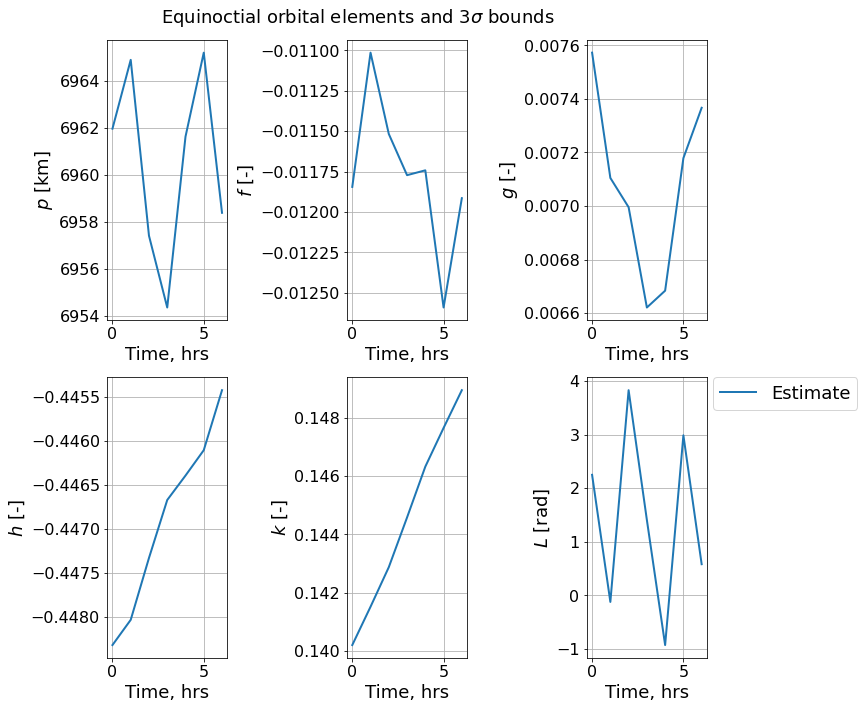

In [12]:
time = time[0:X_est.shape[1]]

fig, axs = plt.subplots(2, 3, figsize=(10, 10))
for ax in axs.flatten():
    ax.set_axis_off()

for ik in range(0,6):
    i = int(ik/3)
    j = ik%3
    axs[i,j].set_axis_on()
    axs[i,j].plot(time/3600,X_est[ik,:], linewidth=2)
    axs[i,j].set_xlabel("Time, hrs", fontsize=18)
    axs[i,j].set_ylabel('z_%.0f' %ik, fontsize=18)
    
    axs[i,j].grid('True')
    axs[i,j].tick_params(axis = 'both', which = 'major', labelsize = 16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
axs[0,0].set_ylabel('$p$ [km]', fontsize=18)
axs[0,1].set_ylabel('$f$ [-]', fontsize=18)
axs[0,2].set_ylabel('$g$ [-]', fontsize=18)
axs[1,0].set_ylabel('$h$ [-]', fontsize=18)
axs[1,1].set_ylabel('$k$ [-]', fontsize=18)
axs[1,2].set_ylabel('$L$ [rad]', fontsize=18)
axs[i,j].legend(['Estimate','3$\sigma$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=18)
plt.suptitle("Equinoctial orbital elements and 3$\sigma$ bounds", fontsize=18)